In [1]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature')
def unpack_hdi_and_filter(df, col):
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

In [8]:
data_dict = {
    'APOE4_Zebra_Collapsed': 'zebra_results/zebra_ft_apoe4.beta_var.tsv', 
    'Amyloid_Zebra_Collapsed': 'zebra_results/zebra_ft_amyloid.beta_var.tsv', 
}

vars_to_check = {
    'APOE4' : 'apoe_risk_score_beta_',
    'Amyloid' : 'amyloid_positive[T.True]_'
}

In [9]:
# update names 
for k in data_dict.keys():
    df = read_results(data_dict[k])
    for v in vars_to_check: 
        if v in k: 
            var = vars_to_check[v] 
    print(k)
    print('Unfiltered Shape:  ' + str(df.shape))
    sub_df = unpack_hdi_and_filter(df, var+'hdi')
    print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
    sub_df.rename_axis(index='Feature', inplace=True)
    
    data_dict[k] = sub_df.sort_values(by=var+'mean')

APOE4_Zebra_Collapsed
Unfiltered Shape:  (649, 15)
Filtered Shape: (266, 18)
Amyloid_Zebra_Collapsed
Unfiltered Shape:  (649, 15)
Filtered Shape: (192, 18)


In [10]:
# check if there are more than 20 features --> if so, only display top and bottom 10 
# otherwise display all 

def display_top_n_feats(df, n, yvar, xvar, xlab, ylab, title):
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    sns.stripplot(data=df_for_display, y=yvar, x=xvar)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

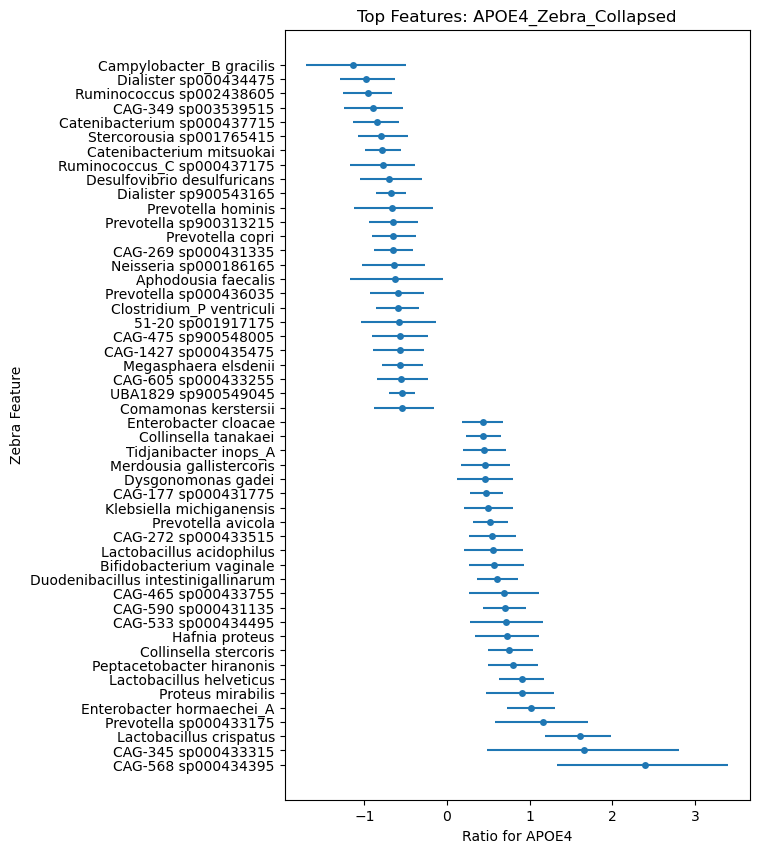

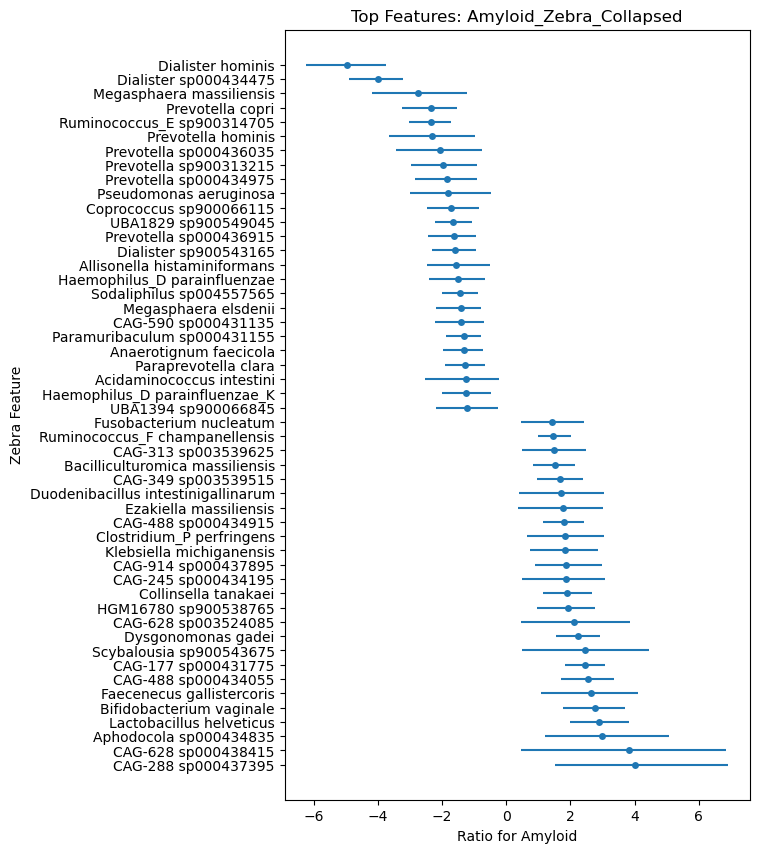

In [11]:
for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            xlab = 'Ratio for ' + v
            var = vars_to_check[v]
            
    ylab = k.split('_')[1] + ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']
    fig, ax = plt.subplots(figsize=(6, 10))
    display_top_n_feats(df_for_display, 25, 'Feature', var+'mean', xlab, ylab,
                        'Top Features: ' + k)